<a href="https://colab.research.google.com/github/sjquill/MSc_diss/blob/main/BREAST_Data/Breast_RSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd

breast_train_data_imputed1 = pd.read_csv("/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/breast_train_data_imputed1.csv")
breast_test_data_imputed1 = pd.read_csv("/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/breast_test_data_imputed1.csv")


In [ ]:
train_data = breast_train_data_imputed1.copy()
test_data = breast_test_data_imputed1.copy()

In [ ]:
column_names = [
    'mask_id',
    'disease_free_survival_status',
    'disease_free_survival_months',
    'race_asian',
    'race_black',
    'race_other',
    'Treatment_CA_6',
    'Treatment_T_4',
    'Treatment_T_6',
    'post_menopausal',
    'tumor_side_right',
    'tumor_side_bilateral',
    'receptor_status_er_pos',
    'receptor_status_pgrn_pos',
    'histologic_grade_inter',
    'histologic_grade_high',
    'her2_status_pos',
    'prior_hormonal_therapy_yes',
    'most_extensive_primary_surgery_mast_NOS',
    'tumor_size_2_to_5cm',
    'tumor_size_over_5cm',
    'num_pos_nodes_1',
    'num_pos_nodes_2+',
    'age_over_fifty'
]
# Set the new column names
train_data.columns = column_names
test_data.columns = column_names

In [ ]:
column_names = train_data.columns.tolist()
print(column_names)

['mask_id', 'disease_free_survival_status', 'disease_free_survival_months', 'race_asian', 'race_black', 'race_other', 'Treatment_CA_6', 'Treatment_T_4', 'Treatment_T_6', 'post_menopausal', 'tumor_side_right', 'tumor_side_bilateral', 'receptor_status_er_pos', 'receptor_status_pgrn_pos', 'histologic_grade_inter', 'histologic_grade_high', 'her2_status_pos', 'prior_hormonal_therapy_yes', 'most_extensive_primary_surgery_mast_NOS', 'tumor_size_2_to_5cm', 'tumor_size_over_5cm', 'num_pos_nodes_1', 'num_pos_nodes_2+', 'age_over_fifty']


In [ ]:
import numpy as np

train_data_y = np.empty(len(train_data), dtype=[('disease_free_survival_status', bool), ('disease_free_survival_months', float)])
train_data_y['disease_free_survival_status'] = train_data['disease_free_survival_status'].astype(bool)
train_data_y['disease_free_survival_months'] = train_data['disease_free_survival_months']

train_data_x = train_data.drop(columns=['disease_free_survival_status', 'disease_free_survival_months', 'mask_id'])

# Repeat for test data.

test_data_y = np.empty(len(test_data), dtype=[('disease_free_survival_status', bool), ('disease_free_survival_months', float)])
test_data_y['disease_free_survival_status'] = test_data['disease_free_survival_status'].astype(bool)
test_data_y['disease_free_survival_months'] = test_data['disease_free_survival_months']

test_data_x = test_data.drop(columns=['disease_free_survival_status', 'disease_free_survival_months', 'mask_id'])


In [ ]:
# Filter the DataFrame for rows where disease_free_survival_status equals 1
df_censored = train_data_y[train_data_y['disease_free_survival_status'] == 1]

# Print the filtered DataFrame
print(df_censored.shape)


(268,)


In [ ]:
print(type(train_data_y))
print(train_data_y[:5])

<class 'numpy.ndarray'>
[(False, 24.64065708) (False, 66.92402464) (False, 69.71663244)
 ( True, 23.19507187) (False, 72.14784394)]


In [ ]:
import numpy as np
import pickle
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import GridSearchCV

#Set the random seed for reproducibility

random_state = 20

# Create the RandomSurvivalForest model
rsf = RandomSurvivalForest(random_state=random_state)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 500, 1000],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [10, 50, 100, 150]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rsf, param_grid=param_grid, cv=5)

# Perform the grid search
grid_search.fit(train_data_x, train_data_y)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'min_samples_leaf': 150, 'min_samples_split': 5, 'n_estimators': 1000}


<ipython-input-13-eb30e986975e>:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


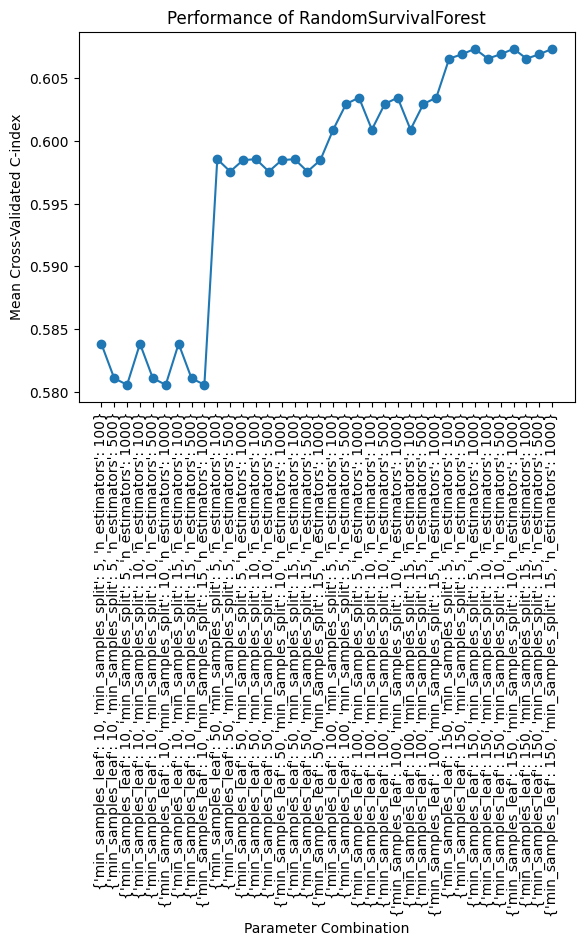

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the mean cross-validated scores for each parameter combination
mean_scores = grid_search.cv_results_['mean_test_score']

# Extract the parameter values from the grid search results
param_values = [str(params) for params in grid_search.cv_results_['params']]

# Create the x-axis values for the plot
x = np.arange(len(param_values))

# Plot the mean scores
plt.plot(x, mean_scores, marker='o')

# Customize the plot
plt.xticks(x, param_values, rotation='vertical')
plt.xlabel('Parameter Combination')
plt.ylabel('Mean Cross-Validated C-index')
plt.title('Performance of RandomSurvivalForest')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:

import numpy as np
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import integrated_brier_score, concordance_index_censored
from sklearn.model_selection import GridSearchCV
import time

best_params = grid_search.best_params_
rsf_best = RandomSurvivalForest(**best_params)

rsf_best.fit(train_data_x, train_data_y)


# Predict survival functions and risk scores

surv_funcs = rsf_best.predict_survival_function(test_data_x)
predicted_risk_scores = rsf_best.predict(test_data_x)  # Predict risk scores


.
times = np.linspace(test_data_y["disease_free_survival_months"].min(),
                    test_data_y["disease_free_survival_months"].max(), 100, endpoint=False)

# Convert the survival functions to the expected 2-D array-like format
survival_array = np.asarray([fn(times).flatten() for fn in surv_funcs])


# Prepare structured arrays for test data
train_data_y_structured = np.array(list(zip(train_data_y["disease_free_survival_status"],
                                           train_data_y["disease_free_survival_months"])),
                                  dtype=[('Status', '?'), ('Time', '<f8')])


# Prepare structured arrays for test data
test_data_y_structured = np.array(list(zip(test_data_y["disease_free_survival_status"],
                                           test_data_y["disease_free_survival_months"])),
                                  dtype=[('Status', '?'), ('Time', '<f8')])

# Compute the IBS
start_ibs_time = time.time()
ibs = integrated_brier_score(survival_train=train_data_y_structured,
                             survival_test=test_data_y_structured,
                             estimate=survival_array,
                             times=times)
end_ibs_time = time.time()

print('Integrated Brier Score:', ibs)

# Compute the C-index
c_index = concordance_index_censored(test_data_y_structured['Status'],
                                     test_data_y_structured['Time'],
                                     predicted_risk_scores)

print('Concordance Index:', c_index[0])

# Print timing information
print("Time for Predicting Survival Functions and Risk Scores:", end_prediction_time - start_prediction_time)
print("Time for Integrated Brier Score Calculation:", end_ibs_time - start_ibs_time)


Integrated Brier Score: 0.08104175912026622
Concordance Index: 0.6698482416870795
Time for Predicting Survival Functions and Risk Scores: 2.551976442337036
Time for Integrated Brier Score Calculation: 0.006296873092651367


In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
best_params = grid_search.best_params_  # Retrieve the best parameters from the grid search results
rsf = RandomSurvivalForest(**best_params)
rsf.fit(train_data_x, train_data_y)
predictions = rsf.predict(test_data_x)
print(predictions)

[40.52854138 14.85678429 15.3819695  13.35562443 12.60532081  7.10060733
 18.87557802 17.35204629 10.53066651 14.13202424  7.65475287 12.77657491
 23.0276526  18.17454148 16.69209229 20.61076433 16.89202663  7.52602162
 26.7077372   5.03710031  7.37372754 15.49584205 15.3819695  35.78432795
 14.29700071 10.28747383 11.74171085 16.94330647 30.5011006  21.95468477
 17.75152909 17.8433396  15.44430968 31.86583859 15.29162738  6.53195902
 24.3430561   7.55444898 11.03694328  8.48782515 19.37941445 14.2949231
  9.49044118 16.85384894 15.03028313 30.7420832   8.80436077 30.82993087
  6.03672311  9.78513477  9.07960437 25.49407905  8.53292891 26.66460197
 14.26999219 23.22214025  7.4628946  11.31992751 25.35092464 11.98322941
 20.56352499 20.13417288 33.71875436 13.17742693 10.28747383 21.11645787
 21.49730149 11.54215439 14.9808483  27.28173225 16.82429029 20.45196022
 19.48370977 15.26945165  7.34610485 14.72452765 20.00035918 17.04501137
 11.86809193 14.34238356 12.15418915 15.54427366 21.

In [ ]:
rsf.score(test_data_x, test_data_y)

0.649041304164203

In [ ]:
### Calculating both the C-Index and the IBS


import numpy as np
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import integrated_brier_score, concordance_index_censored
from sklearn.model_selection import GridSearchCV
import time

# Set the random seed for reproducibility
random_state = 20

# Create the RandomSurvivalForest model
rsf = RandomSurvivalForest(random_state=random_state)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 500, 1000],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [10, 15, 20]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rsf, param_grid=param_grid, cv=5)

# Perform the grid search
start_tuning_time = time.time()
grid_search.fit(train_data_x, train_data_y)
end_tuning_time = time.time()

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Fit the model with the best parameters
best_params = grid_search.best_params_
rsf_best = RandomSurvivalForest(**best_params)
start_training_time = time.time()
rsf_best.fit(train_data_x, train_data_y)
end_training_time = time.time()

# Predict survival functions and risk scores
start_prediction_time = time.time()
surv_funcs = rsf_best.predict_survival_function(test_data_x)
predicted_risk_scores = rsf_best.predict(test_data_x)  # Predict risk scores
end_prediction_time = time.time()

# .
times = np.linspace(test_data_y["disease_free_survival_months"].min(),
                    test_data_y["disease_free_survival_months"].max(), 100, endpoint=False)

# Convert the survival functions to the expected 2-D array-like format
survival_array = np.asarray([fn(times).flatten() for fn in surv_funcs])


# Prepare structured arrays for test data
train_data_y_structured = np.array(list(zip(train_data_y["disease_free_survival_status"],
                                           train_data_y["disease_free_survival_months"])),
                                  dtype=[('Status', '?'), ('Time', '<f8')])


# Prepare structured arrays for test data
test_data_y_structured = np.array(list(zip(test_data_y["disease_free_survival_status"],
                                           test_data_y["disease_free_survival_months"])),
                                  dtype=[('Status', '?'), ('Time', '<f8')])

# Compute the IBS
start_ibs_time = time.time()
ibs = integrated_brier_score(survival_train=train_data_y_structured,
                             survival_test=test_data_y_structured,
                             estimate=survival_array,
                             times=times)
end_ibs_time = time.time()

print('Integrated Brier Score:', ibs)

# Compute the C-index
c_index = concordance_index_censored(test_data_y_structured['Status'],
                                     test_data_y_structured['Time'],
                                     predicted_risk_scores)

print('Concordance Index:', c_index[0])

# Print timing information
print("Time for GridSearchCV (Tuning):", end_tuning_time - start_tuning_time)
print("Time for Model Training:", end_training_time - start_training_time)
print("Time for Predicting Survival Functions and Risk Scores:", end_prediction_time - start_prediction_time)
print("Time for Integrated Brier Score Calculation:", end_ibs_time - start_ibs_time)


Best Parameters: {'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 100}
Integrated Brier Score: 0.08125948337231158
Concordance Index: 0.6431849536841513
Time for GridSearchCV (Tuning): 1887.0017688274384
Time for Model Training: 2.476710557937622
Time for Predicting Survival Functions and Risk Scores: 1.030818223953247
Time for Integrated Brier Score Calculation: 0.009633302688598633


/usr/local/lib/python3.10/dist-packages/sksurv/metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


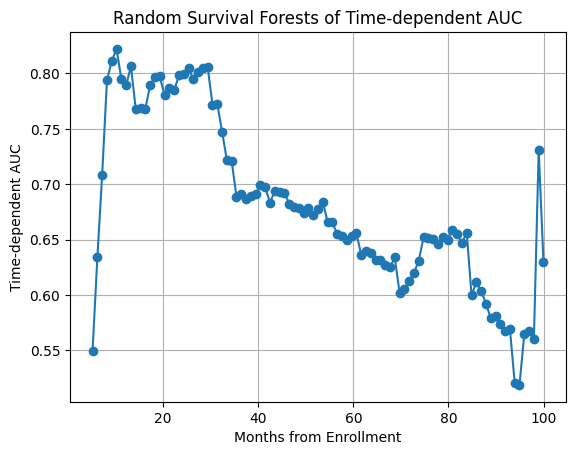

In [ ]:
from sksurv.metrics import cumulative_dynamic_auc
# Predict cumulative hazard functions
start_prediction_time = time.time()
cum_hazards = rsf_best.predict_cumulative_hazard_function(test_data_x, return_array=False)
end_prediction_time = time.time()

# Evaluate the cumulative hazard functions at the times of interest to get the risk scores
rsf_risk_scores = np.row_stack([chf(times) for chf in cum_hazards])

# Compute the time-dependent AUC using the cumulative_dynamic_auc function
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(train_data_y_structured, test_data_y_structured, rsf_risk_scores, times)

# Plot the results
import matplotlib.pyplot as plt
plt.plot(times, rsf_auc, marker="o")
plt.axhline(rsf_mean_auc, linestyle="--")
plt.title("Random Survival Forests of Time-dependent AUC")
plt.xlabel("Months from Enrollment")
plt.ylabel("Time-dependent AUC")
plt.grid(True)
plt.show()


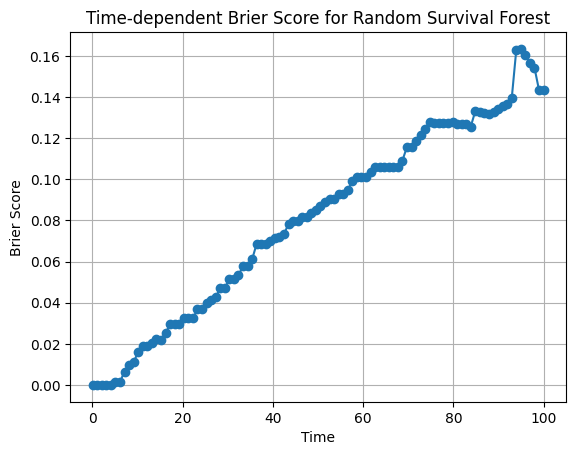

Time for Brier Score Calculation: 0.02451801300048828


In [ ]:
from sksurv.metrics import brier_score

# Calculate the Brier scores
start_brier_score_time = time.time()
rsf_brier_score_times, rsf_brier_scores = brier_score(train_data_y_structured, test_data_y_structured, survival_array, times)
end_brier_score_time = time.time()

# Plot the time-dependent Brier scores
plt.plot(rsf_brier_score_times, rsf_brier_scores, marker="o")
plt.title("Time-dependent Brier Score for Random Survival Forest")
plt.xlabel("Time")
plt.ylabel("Brier Score")
plt.grid(True)
plt.show()

# Print timing information
print("Time for Brier Score Calculation:", end_brier_score_time - start_brier_score_time)


In [ ]:
import numpy as np
#Save times?
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Time_depedent_AUC_and_Brier_plots/rsf_times.npy', times)
# save the numpy arrays to the specified directory
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Time_depedent_AUC_and_Brier_plots/rsf_auc.npy', rsf_auc)
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Time_depedent_AUC_and_Brier_plots/rsf_mean_auc.npy', rsf_mean_auc)
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Time_depedent_AUC_and_Brier_plots/rsf_brier_score_times.npy', rsf_brier_score_times)
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Time_depedent_AUC_and_Brier_plots/rsf_brier_scores.npy', rsf_brier_scores)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the mean cross-validated scores for each parameter combination
mean_scores = grid_search.cv_results_['mean_test_score']

# Extract the parameter values from the grid search results
param_values = [str(params) for params in grid_search.cv_results_['params']]

# Create the x-axis values for the plot
x = np.arange(len(param_values))

# Plot the mean scores
plt.plot(x, mean_scores, marker='o')

# Customize the plot
plt.xticks(x, param_values, rotation='vertical')
plt.xlabel('Parameter Combination')
plt.ylabel('Mean Cross-Validated C-index')
plt.title('Performance of RandomSurvivalForest')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:

###
from sklearn.utils import resample
import numpy as np
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import GridSearchCV

# Number of bootstrap iterations
n_bootstrap_iterations = 1000

# Arrays to store bootstrap C-indices and IBS scores
bootstrap_c_indices_rsf = np.zeros(n_bootstrap_iterations)
bootstrap_ibs_scores_rsf = np.zeros(n_bootstrap_iterations)

# Define the RandomSurvivalForest model with the best parameters
rsf_best = RandomSurvivalForest(**best_params)

# Convert original test data to structured array format
test_y_structured = np.array(list(zip(test_data_y["disease_free_survival_status"],
                                      test_data_y["disease_free_survival_months"])),
                             dtype=[('Status', '?'), ('Time', '<f8')])

for i in range(n_bootstrap_iterations):
    # Perform bootstrap resampling of the training data
    bootstrap_train_x, bootstrap_train_y = resample(train_data_x, train_data_y)

    # Convert resampled bootstrap data to structured array format
    bootstrap_train_y_structured = np.array(list(zip(bootstrap_train_y["disease_free_survival_status"],
                                                     bootstrap_train_y["disease_free_survival_months"])),
                                            dtype=[('Status', '?'), ('Time', '<f8')])

    # Fit the model using the resampled training data
    rsf_best.fit(bootstrap_train_x, bootstrap_train_y_structured)

    # Get the range of follow-up time for the original test data
    min_time = test_y_structured["Time"].min()
    max_time = test_y_structured["Time"].max()

    # 
    times = np.linspace(min_time, max_time, 100, endpoint=False)

    # Predict risk scores
    predicted_risk_scores = rsf_best.predict(test_data_x)  # Use the original test data here

    # Compute and store the C-index
    c_index = concordance_index_censored(test_y_structured['Status'],  # Use the original test data here
                                         test_y_structured['Time'],  # Use the original test data here
                                         predicted_risk_scores)
    bootstrap_c_indices_rsf[i] = c_index[0]

    # Predict survival functions
    surv_funcs = rsf_best.predict_survival_function(test_data_x)  # Use the original test data here

    # Convert the survival functions to the expected 2-D array-like format
    survival_array = np.asarray([fn(times).flatten() for fn in surv_funcs])

    # Compute and store the IBS
    ibs = integrated_brier_score(survival_train=bootstrap_train_y_structured,
                                  survival_test=test_y_structured,  # Use the original test data here
                                  estimate=survival_array,
                                  times=times)
    bootstrap_ibs_scores_rsf[i] = ibs

# Compute and print confidence intervals
lower_percentile_c_index = np.percentile(bootstrap_c_indices_rsf, 2.5)
upper_percentile_c_index = np.percentile(bootstrap_c_indices_rsf, 97.5)
lower_percentile_ibs = np.percentile(bootstrap_ibs_scores_rsf, 2.5)
upper_percentile_ibs = np.percentile(bootstrap_ibs_scores_rsf, 97.5)

print('Bootstrap 95% confidence interval for the C-index: ({:.2f}, {:.2f})'.format(lower_percentile_c_index, upper_percentile_c_index))
print('Bootstrap 95% confidence interval for the IBS: ({:.2f}, {:.2f})'.format(lower_percentile_ibs, upper_percentile_ibs))


Bootstrap 95% confidence interval for the C-index: (0.64, 0.68)
Bootstrap 95% confidence interval for the IBS: (0.08, 0.08)


In [ ]:
import numpy as np

# save the numpy arrays to the specified directory
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Confidence_intervals_breast_IBS_cindex/bootstrap_c_indices_rsf.npy', bootstrap_c_indices_rsf)
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Confidence_intervals_breast_IBS_cindex/bootstrap_ibs_scores_rsf.npy', bootstrap_ibs_scores_rsf)

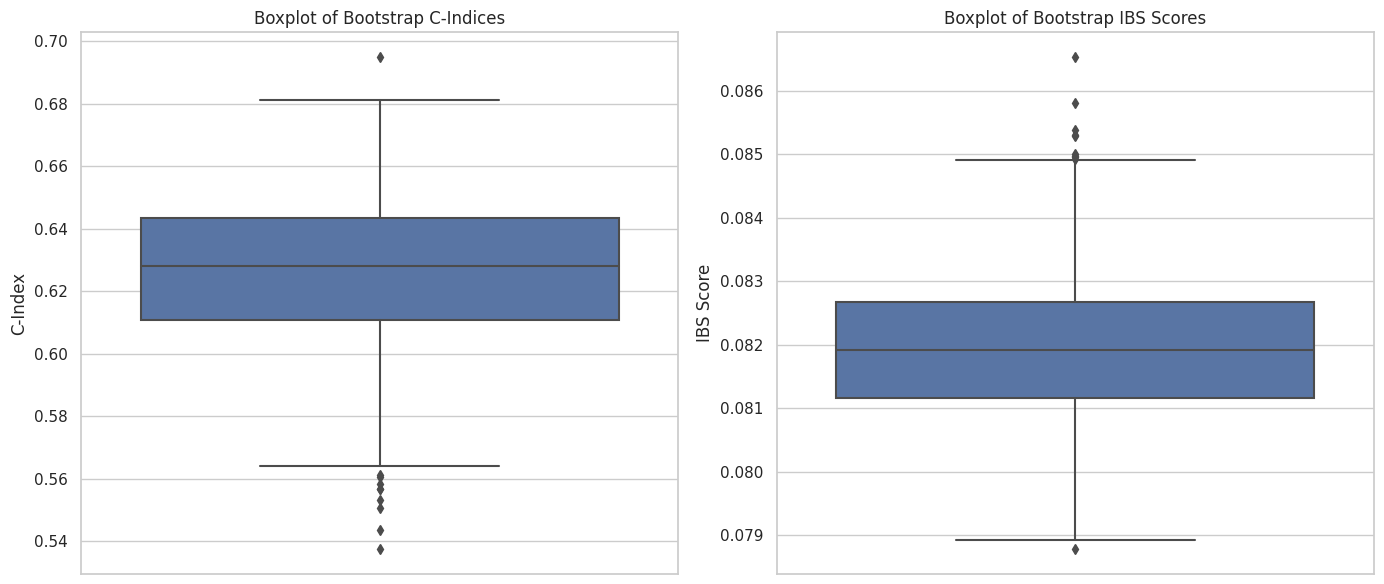

In [ ]:



##  Resampling on the training set and on the test set.
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Create a figure
plt.figure(figsize=(14, 6))

# Subplot for C-index
plt.subplot(1, 2, 1)
sns.boxplot(y=bootstrap_c_indices_rsf)
plt.title("Boxplot of Bootstrap C-Indices")
plt.ylabel("C-Index")

# Subplot for IBS
plt.subplot(1, 2, 2)
sns.boxplot(y=bootstrap_ibs_scores_rsf)
plt.title("Boxplot of Bootstrap IBS Scores")
plt.ylabel("IBS Score")

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# save the numpy arrays to the specified directory
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Confidence_intervals_breast_IBS_cindex/bootstrap_c_indices_rsf.npy', bootstrap_c_indices_rsf)
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Confidence_intervals_breast_IBS_cindex/bootstrap_ibs_scores_rsf.npy', bootstrap_ibs_scores_rsf)
